<a href="https://colab.research.google.com/github/PinChunPai/Higgs_Boson/blob/main/Higgs_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Find Higgs**
A practical project for machine learning using [Kaggle dataset](https://www.kaggle.com/competitions/higgs-boson/data)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Setup**
Import commonly used packages. Download from Kaggle and unzip the file.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
import json

# Specify the file path
file_path = '/content/drive/MyDrive/Project/Higgs/kaggle.json'

# Open the JSON file and load its contents
with open(file_path, 'r') as file:
    api = json.load(file)

In [ ]:
!pip install kaggle --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.4-py3-none-any.whl size=111926 sha256=52558739c7ce187b2c63539de482267a70c8e5bdd7b32f1b8232947694986feb
  Stored in directory: /root/.cache/pip/wheels/96/ea/6e/1ef402d5911f0536091cd6d9357682c64214efa960eab358b4
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Project/Higgs/kaggle.json ~/.kaggle/

In [ ]:
!kaggle competitions download -c higgs-boson

 96% 52.0M/54.3M [00:03<00:00, 19.7MB/s]
100% 54.3M/54.3M [00:03<00:00, 14.9MB/s]


In [ ]:
!unzip /content/higgs-boson.zip

Archive:  /content/higgs-boson.zip
  inflating: HiggsBosonCompetition_AMSMetric_rev1.py  
  inflating: random_submission.zip   
  inflating: test.zip                
  inflating: training.zip            


In [ ]:
!unzip /content/test.zip

Archive:  /content/test.zip
  inflating: test.csv                


In [ ]:
!unzip /content/training.zip

Archive:  /content/training.zip
  inflating: training.csv            


## **Look at data**
All needed data is stored in cloud derive. We will train and test models based on training data recorded in `training.csv`, and finally make predicitons on test data stored in `test.csv`. Before constructing models, let's take a look at these data.

In [ ]:
df = pd.read_csv('/content/training.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 33 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   EventId                      250000 non-null  int64  
 1   DER_mass_MMC                 250000 non-null  float64
 2   DER_mass_transverse_met_lep  250000 non-null  float64
 3   DER_mass_vis                 250000 non-null  float64
 4   DER_pt_h                     250000 non-null  float64
 5   DER_deltaeta_jet_jet         250000 non-null  float64
 6   DER_mass_jet_jet             250000 non-null  float64
 7   DER_prodeta_jet_jet          250000 non-null  float64
 8   DER_deltar_tau_lep           250000 non-null  float64
 9   DER_pt_tot                   250000 non-null  float64
 10  DER_sum_pt                   250000 non-null  float64
 11  DER_pt_ratio_lep_tau         250000 non-null  float64
 12  DER_met_phi_centrality       250000 non-null  float64
 13 

In [ ]:
df_test = pd.read_csv('/content/test.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550000 entries, 0 to 549999
Data columns (total 31 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   EventId                      550000 non-null  int64  
 1   DER_mass_MMC                 550000 non-null  float64
 2   DER_mass_transverse_met_lep  550000 non-null  float64
 3   DER_mass_vis                 550000 non-null  float64
 4   DER_pt_h                     550000 non-null  float64
 5   DER_deltaeta_jet_jet         550000 non-null  float64
 6   DER_mass_jet_jet             550000 non-null  float64
 7   DER_prodeta_jet_jet          550000 non-null  float64
 8   DER_deltar_tau_lep           550000 non-null  float64
 9   DER_pt_tot                   550000 non-null  float64
 10  DER_sum_pt                   550000 non-null  float64
 11  DER_pt_ratio_lep_tau         550000 non-null  float64
 12  DER_met_phi_centrality       550000 non-null  float64
 13 

I notice that there are two extra columns in training data: `Weight` and `Label`. Our goal is to predict `Label`, which indicates whether Higgs is detected or not. It is interesting to have another related quantities. We can dig to see how these two quantities are related.

In [ ]:
display(df[df['Label']=='b'].Weight.describe())
print('Weight of background.')
print()
display(df[df['Label']=='s'].Weight.describe())
print('Weight of signal.')
print()

count    164333.000000
mean          2.501018
std           1.794235
min           0.064061
25%           1.340468
50%           2.080362
75%           4.353313
max           7.822543
Name: Weight, dtype: float64

Weight of background.



count    85667.000000
mean         0.008078
std          0.008231
min          0.001502
25%          0.001503
50%          0.001503
75%          0.018636
max          0.018636
Name: Weight, dtype: float64

Weight of signal.



In [ ]:
df[df.Label == 's'].Weight.value_counts()

0.001503    38552
0.018636    32352
0.002653     7789
0.001502     6974
Name: Weight, dtype: int64

In [ ]:
df[df.Label == 'b'].Weight.value_counts()

1.681611    17259
0.744056    10351
1.454848     6818
0.073899     5051
0.071357     4657
            ...  
2.807358        1
5.430880        1
2.311713        1
2.115398        1
1.877474        1
Name: Weight, Length: 104092, dtype: int64

It is obvious that background data has significantly larger `Weight` than signal data has. This fact provides us some different idea to make prediction. We can design classification models to predict `Label` directly or design regression models to predict `Weight`. Both of them will be experimented.

### **Histograms**

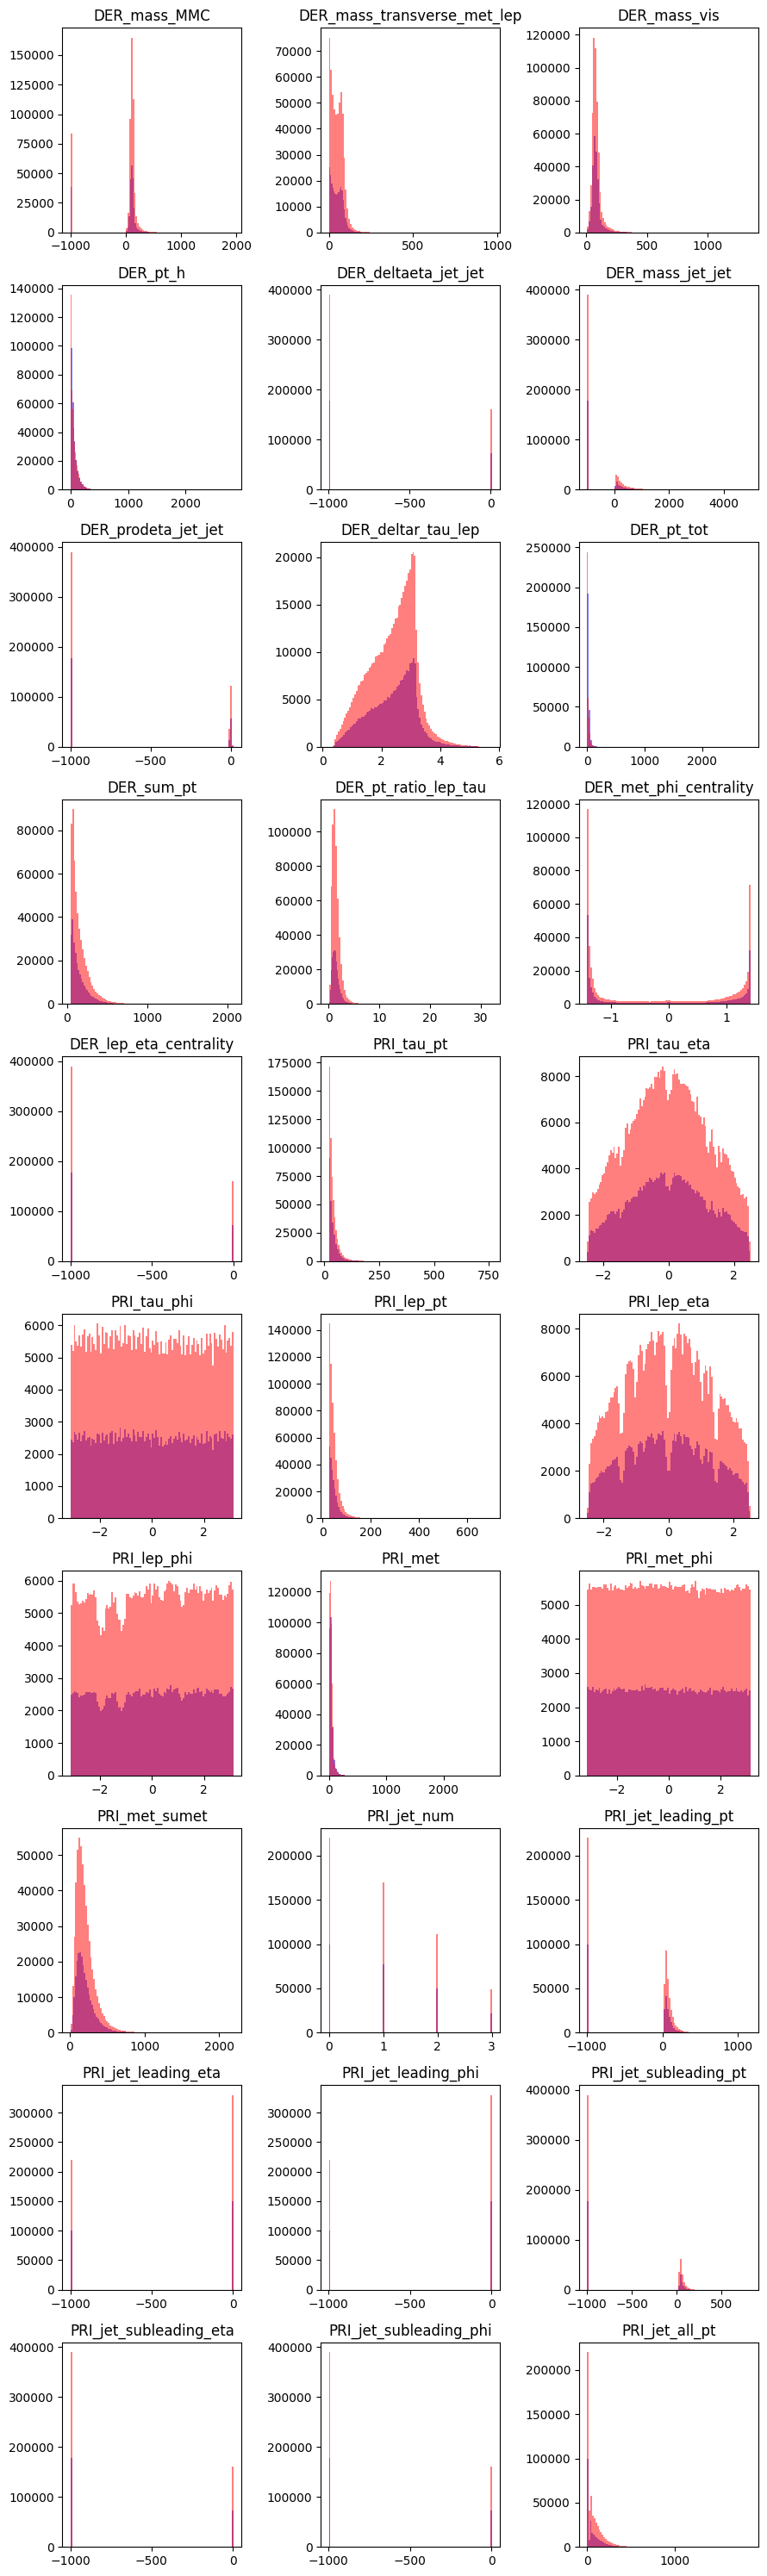

In [ ]:
total = 30
fig, axs = plt.subplots(10, 3, figsize=(9, 30))
columns = list(df.columns)
for i in range(10):
    for j in range(3):
        idx = i * 3 + j
        axs[i, j].hist(df.iloc[:,idx+1], bins = 100, alpha = 0.5, label = 'training data', color = 'b')
        axs[i, j].hist(df_test.iloc[:,idx+1] , bins = 100, alpha = 0.5, label =  'testing data', color = 'r')
        axs[i, j].set_title(f'{columns[idx+1]}')
plt.tight_layout()
plt.show()

The distribution of two sets looks similar. Many of them have values $-999.0$, which means meaningless or unknown variables. Let's see whether they are meaningful in some sense.

In [ ]:
train = df.drop('EventId',axis=1)

In [ ]:
pd.concat( [(train[train.Label == 'b'].isin([-999.0]).sum(axis=0) /164333),(train[train.Label == 's'].isin([-999.0]).sum(axis=0) /85667)],axis=1).rename(columns = {0:'b', 1:'s'})

,b,s
DER_mass_MMC,0.214680,0.033093
DER_mass_transverse_met_lep,0.000000,0.000000
DER_mass_vis,0.000000,0.000000
DER_pt_h,0.000000,0.000000
DER_deltaeta_jet_jet,0.756117,0.621033
DER_mass_jet_jet,0.756117,0.621033
DER_prodeta_jet_jet,0.756117,0.621033
DER_deltar_tau_lep,0.000000,0.000000
DER_pt_tot,0.000000,0.000000
DER_sum_pt,0.000000,0.000000


Here are some insights. First of all $-999.0$ appears more frequently in background than in signal. Furthermore we can see that some quantities are strongly related. They can be classify into three groups: $[0.214, 0.033], [0.756,0.621], [0.452,0.297]$. We can pick up three representations respectively: `DER_mass_MMC`,  `DER_deltaeta_jet_jet` and `PRI_jet_leading_pt`.

### **Remove missing values**

To capture these properties, I create three new columns `M1`, `M2` and `M3` to denote the three type of missing values.

In [ ]:
def ismissing(x):
  return 1 if x == -999.0 else 0

def missings(df):
  df['M1'] = df.DER_mass_MMC.apply(ismissing)
  df['M2'] = df.DER_deltaeta_jet_jet.apply(ismissing)
  df['M3'] = df.PRI_jet_leading_pt.apply(ismissing)
  return df

In [ ]:
train = missings(train)
df_test = missings(df_test)

In [ ]:
train[train.values == -999.0] = np.nan
df_test[df_test.values == -999.0] = np.nan

Let's look at the distribution again, without bothered by $-999.0$.

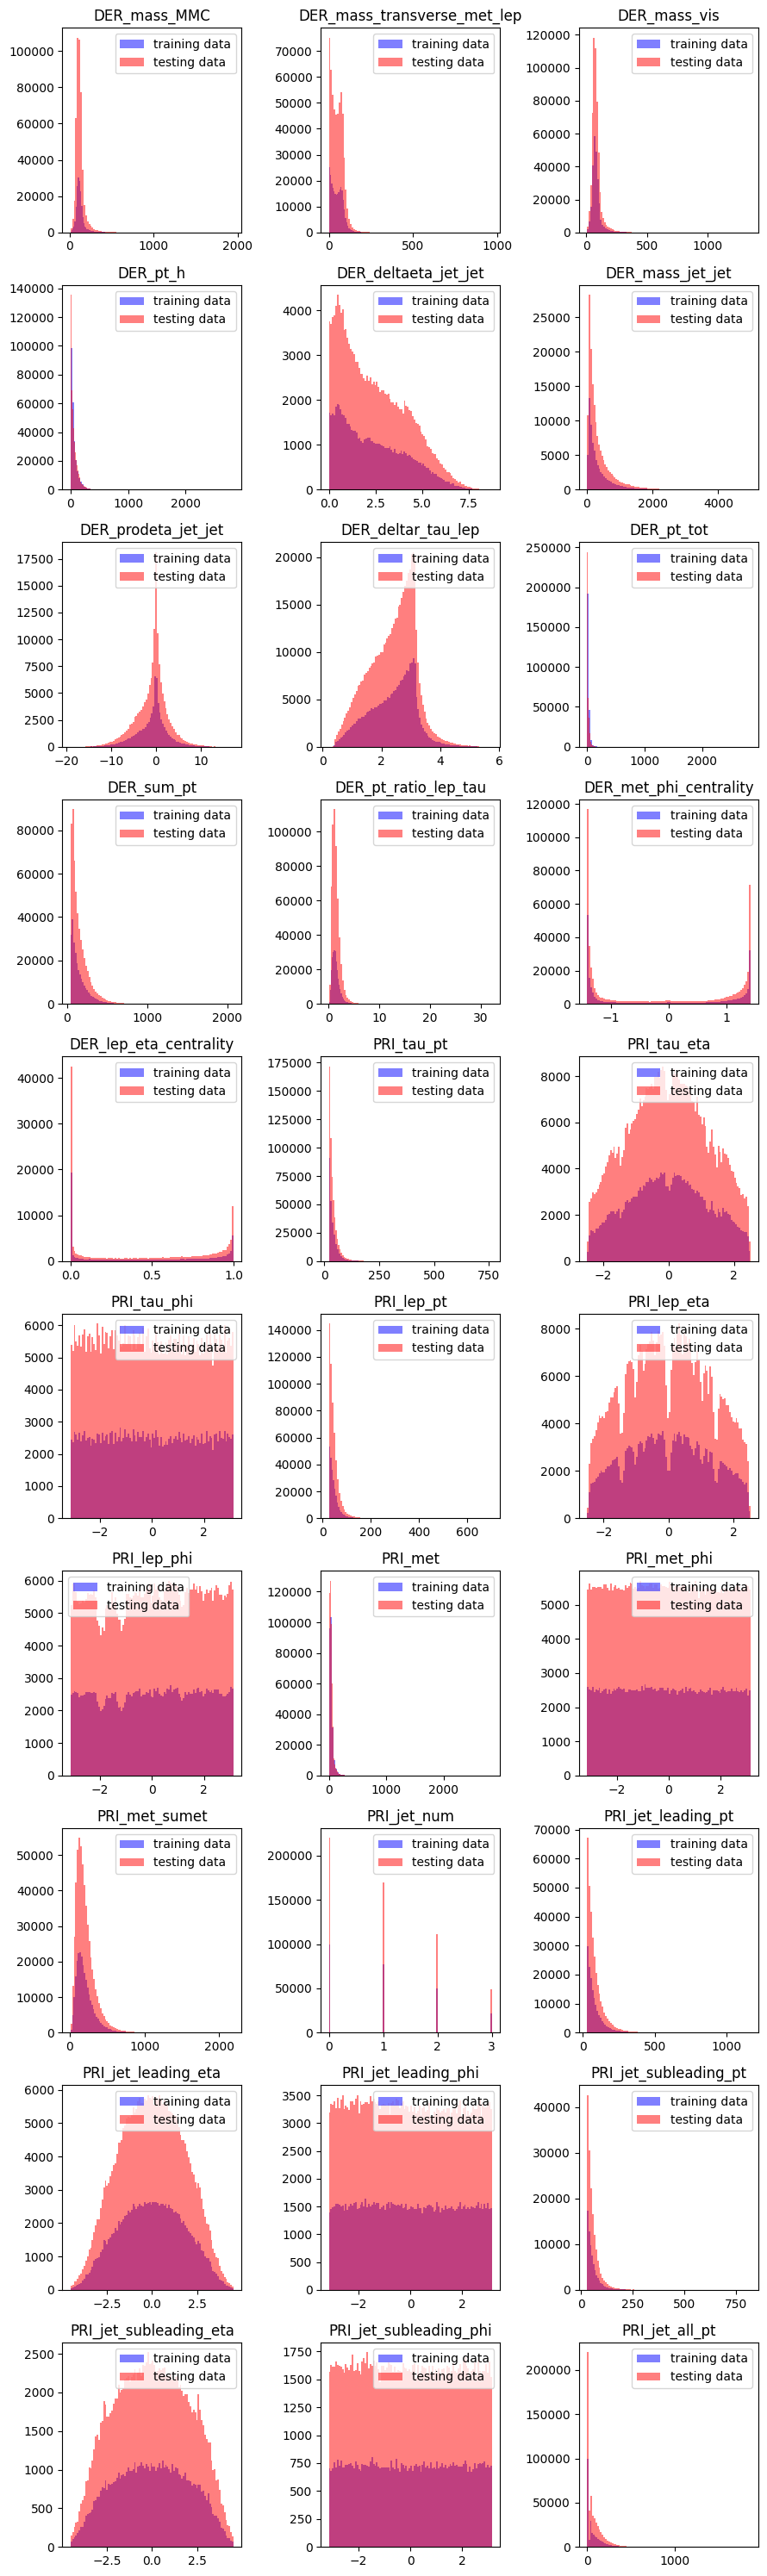

In [ ]:
fig, axs = plt.subplots(10, 3, figsize=(9, 30))
columns = list(train.columns)
for i in range(10):
    for j in range(3):
        idx = i * 3 + j
        axs[i, j].hist(train.iloc[:,idx], bins = 100, alpha = 0.5, label = 'training data', color = 'b')
        axs[i, j].hist(df_test.iloc[:,idx+1] , bins = 100, alpha = 0.5, label =  'testing data', color = 'r')
        axs[i, j].set_title(f'{columns[idx]}')
        axs[i,j].legend()
plt.tight_layout()
plt.show()

Now they look quite similar. We may want to further normalize or log these quantities to get more "normal" distribution. Before doing so let's see whether these quantities behave differently for signal and background.

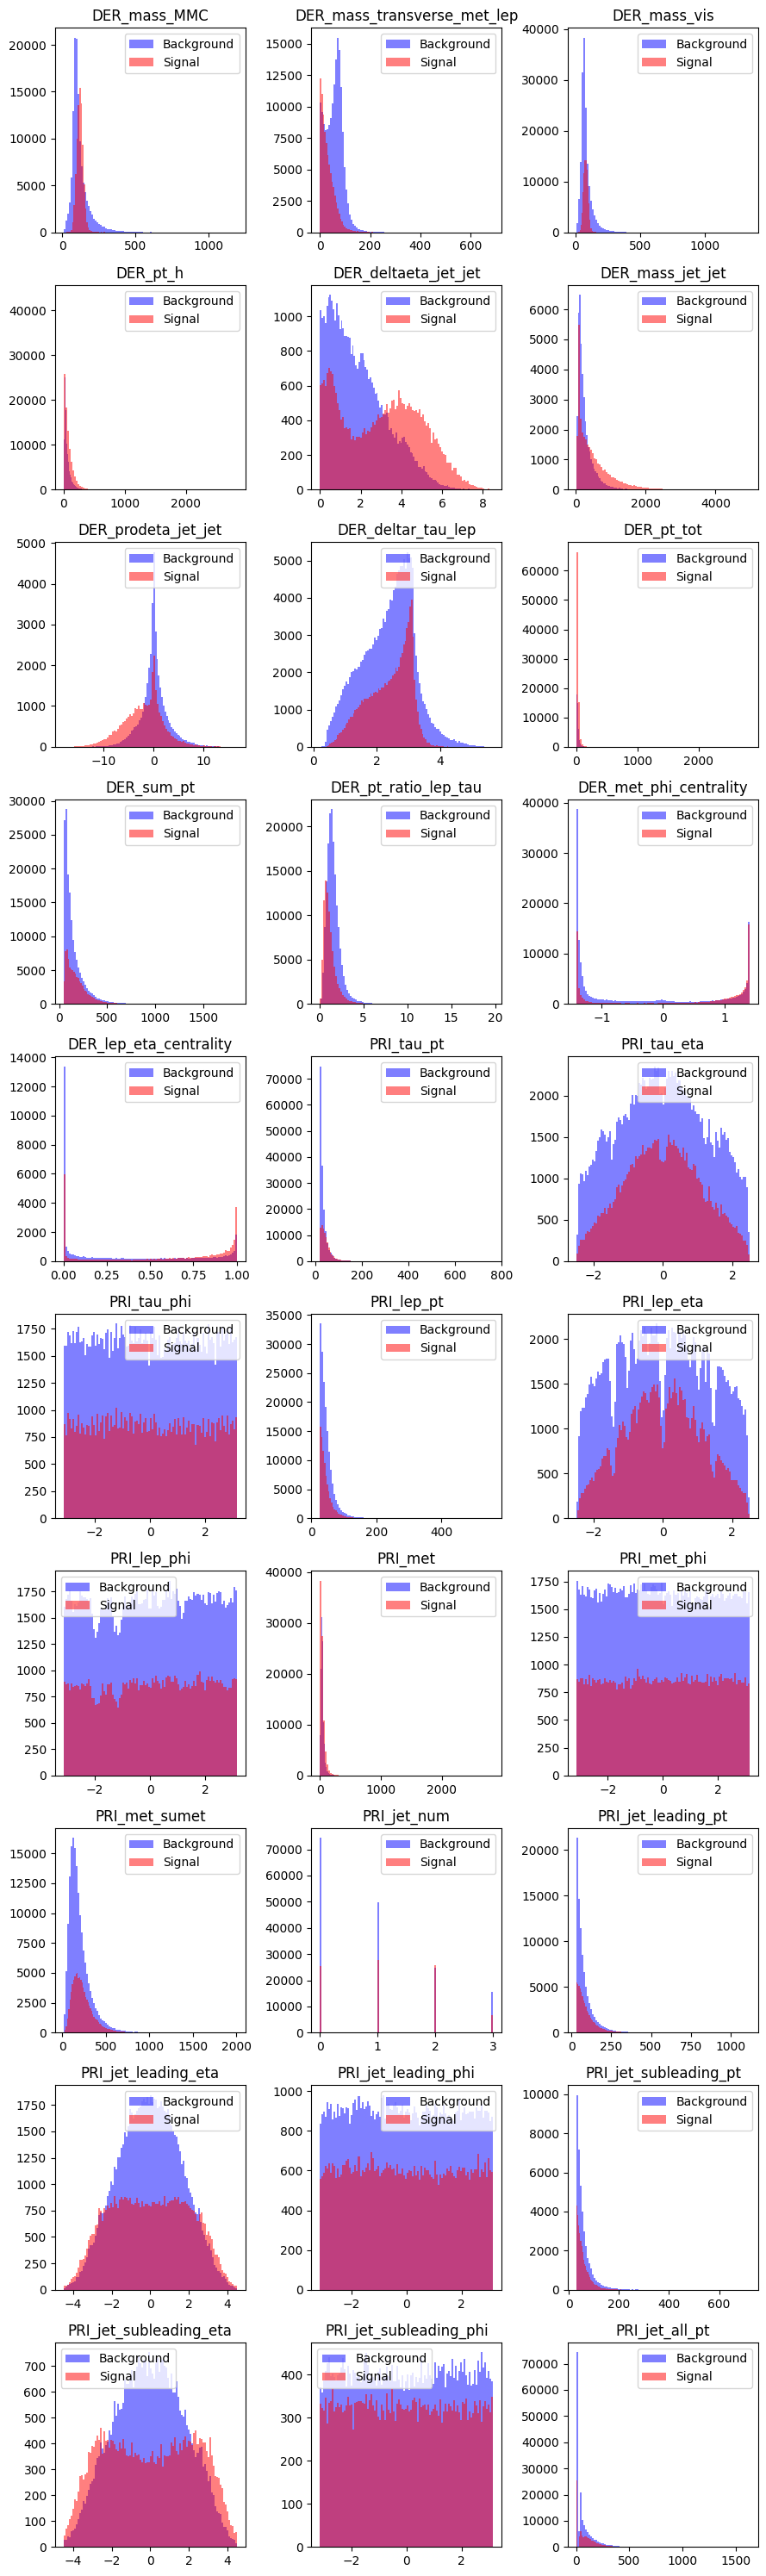

In [ ]:
fig, axs = plt.subplots(10, 3, figsize=(9, 30))
for i in range(10):
    for j in range(3):
        idx = i * 3 + j
        axs[i, j].hist(train[train.Label=='b'].iloc[:,idx], bins = 100, alpha = 0.5, label = 'Background', color = 'b')
        axs[i, j].hist(train[train.Label=='s'].iloc[:,idx], bins = 100, alpha = 0.5, label =  'Signal', color = 'r')
        axs[i, j].set_title(f'{columns[idx]}')
        axs[i,j].legend()
plt.tight_layout()
plt.show()

It seems that some of them are useful to distinguish background and signals. I would like to log some of them and then normalize it. This process will not affect decesion tree based models so let's set up a baseline by random forests first.

## **Neural Networks**
Now let's try neural network structure. It is supposed to be able to cathch higher order of features so may be a more relevant tool to use.

### **Setup**
We will use fastai library to construct and train neural networks.

In [ ]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.5 MB/s eta 0:00:00
Mounted at /content/gdrive


In [ ]:
from fastbook import *
from fastai.tabular.all import *

### **Preprocessing**

Unlike decision tree models, we should carefully deal with $-999.0$ because it affects normalization of numerical values. A reasonable way is to remove such values first, normalize variables and finally fillna by other values. Some variable ranges cross $0$ so I want to standardize it to (0,1) first and then use log1 to transform the shape. Specifically I want to

1. Remove $-999.0$ from each variables
2. Recording missing in three columns:
 * M1 for `[DER_mass_MMC]`
 * M2 for `[DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_lep_eta_centrality,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi]`
 * M3 for `[PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi]`
3. Standardize variables to make them in range (0,1)
4. fillna(-2) so that we get a special "token" for missing values. We should do experiments on this value.

In [ ]:
df = pd.read_csv('/content/training.csv')
df_test = pd.read_csv('/content/test.csv')

In [ ]:
M1_columns = ['DER_mass_MMC']
M2_columns = ['DER_deltaeta_jet_jet','DER_mass_jet_jet','DER_prodeta_jet_jet','DER_lep_eta_centrality','PRI_jet_subleading_pt','PRI_jet_subleading_eta','PRI_jet_subleading_phi']
M3_columns= ['PRI_jet_leading_pt','PRI_jet_leading_eta','PRI_jet_leading_phi']

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

def preprocess(df):
  df['M1'] = df[M1_columns[0]].apply(lambda x: 0 if x == -999.0 else 1)
  df['M2'] = df[M2_columns[0]].apply(lambda x: 0 if x == -999.0 else 1)
  df['M3'] = df[M3_columns[0]].apply(lambda x: 0 if x == -999.0 else 1)
  df[df.values == -999.0] = np.nan
  return df

In [ ]:
xs = preprocess(df.drop(['EventId','Label', 'Weight'],axis=1))
test_xs = preprocess(df_test.drop(['EventId'],axis=1))

In [ ]:
xs.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_tau,DER_met_phi_centrality,DER_lep_eta_centrality,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,M1,M2,M3
0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,1.582,1.396,0.2,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,1,1,1
1,160.937,68.768,103.235,48.146,NaN,NaN,NaN,3.473,2.078,125.157,0.879,1.414,NaN,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,NaN,NaN,NaN,46.226,1,0,1
2,NaN,162.172,125.953,35.635,NaN,NaN,NaN,3.148,9.336,197.814,3.776,1.414,NaN,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,NaN,NaN,NaN,44.251,0,0,1
3,143.905,81.417,80.943,0.414,NaN,NaN,NaN,3.310,0.414,75.968,2.354,-1.285,NaN,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,NaN,NaN,NaN,NaN,NaN,NaN,-0.000,1,0,0
4,175.864,16.915,134.805,16.405,NaN,NaN,NaN,3.891,16.405,57.983,1.056,-1.385,NaN,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000,1,0,0


In [ ]:
scale_column = xs.drop(['M1','M2','M3'],axis=1).columns
scaler = scaler.fit(xs[scale_column])
xs[scale_column] = scaler.transform(xs[scale_column])
test_xs[scale_column] = scaler.transform(test_xs[scale_column])

In [ ]:
xs.fillna(-2, inplace=True)
test_xs.fillna(-2, inplace=True)

In [ ]:
xs = pd.concat([xs, df['Label']], axis=1)

In [ ]:
dls = TabularDataLoaders.from_df(df = xs, cont_names= list(xs.drop(['Label'],axis=1).columns), y_names= ['Label'],   bs = 128,seed = 42)

In [ ]:
learner = tabular_learner(dls, metrics=accuracy)

In [ ]:
learner.summary()

TabularModel (Input shape: 128 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 33            
BatchNorm1d                               66         True      
____________________________________________________________________________
                     128 x 200           
Linear                                    6600       True      
ReLU                                                           
BatchNorm1d                               400        True      
____________________________________________________________________________
                     128 x 100           
Linear                                    20000      True      
ReLU                                                           
BatchNorm1d                               200        True      
____________________________________________________________________________
                     128 x 2             
Linear                                    202        

The default is a simple NN. Let's try to train it.

In [ ]:
learner.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.398913,0.390939,0.822720,00:12
1,0.387736,0.370667,0.835100,00:12
2,0.374201,0.366685,0.836400,00:12
3,0.383365,0.363569,0.838600,00:12
4,0.367127,0.358096,0.840320,00:12
5,0.368805,0.360940,0.839000,00:12
6,0.366250,0.356917,0.840300,00:12
7,0.363690,0.354518,0.841040,00:12
8,0.349161,0.354344,0.841360,00:12
9,0.354199,0.354445,0.841140,00:12


Amazingly, this simple NN gives roughly the same accuracy as xgb and rf. It runs very fast. Take a look at its prediciton.

In [ ]:
dl = dls.test_dl(test_xs)
learner.get_preds(dl=dl)

(tensor([[0.9956, 0.0044],
         [0.9663, 0.0337],
         [0.4959, 0.5041],
         ...,
         [0.9427, 0.0573],
         [0.7187, 0.2813],
         [0.8659, 0.1341]]),
 None)

### **Experiments**

Now we can quickly test some idea. First of all let's try different batch sizes.

#### **Batch size**

In [ ]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)

In [ ]:
def bs_test(bs,epochs=5):
  dls = TabularDataLoaders.from_df(df = xs, cont_names= list(xs.drop(['Label'],axis=1).columns), y_names= ['Label'],   bs = bs,seed = 42)
  learner = tabular_learner(dls, metrics=accuracy)
  learner.fit_one_cycle(epochs)
  return learner

In [ ]:
learn_128 = bs_test(128)

epoch,train_loss,valid_loss,accuracy,time
0,0.395713,0.375134,0.833980,00:12
1,0.378205,0.364596,0.836940,00:12
2,0.374702,0.358460,0.840160,00:12
3,0.364343,0.354450,0.842460,00:12
4,0.366843,0.351553,0.843280,00:13


In [ ]:
learn_64 = bs_test(64)

epoch,train_loss,valid_loss,accuracy,time
0,0.414956,0.382912,0.828140,00:24
1,0.385038,0.367132,0.836060,00:24
2,0.378596,0.365879,0.838020,00:24
3,0.373453,0.360265,0.841300,00:24
4,0.383979,0.358061,0.842140,00:24


We see that $bs  = 64 $ converges slower than $bs=128$, but it is less likely to overfit (training loss is still quite high with roughly the same outcome quality). Here is a trade-off between efficiency and quality.

In [ ]:
bs_test(256)

epoch,train_loss,valid_loss,accuracy,time
0,0.383703,0.380409,0.828240,00:06
1,0.370465,0.365500,0.835420,00:06
2,0.365529,0.358918,0.839160,00:06
3,0.365227,0.356136,0.840260,00:06
4,0.357887,0.355235,0.840080,00:06


In [ ]:
bs_test(512)

epoch,train_loss,valid_loss,accuracy,time
0,0.396611,0.386754,0.827560,00:03
1,0.376372,0.364314,0.838480,00:03
2,0.364931,0.361747,0.838060,00:03
3,0.359359,0.356495,0.841320,00:03
4,0.356965,0.355294,0.841640,00:03


In [ ]:
bs_test(32)

epoch,train_loss,valid_loss,accuracy,time
0,0.427050,0.394187,0.825260,00:48
1,0.386632,0.372969,0.834880,00:48
2,0.389935,0.369448,0.837100,00:48
3,0.379542,0.364923,0.838880,00:48
4,0.383259,0.368652,0.838020,00:48


It seems that $bs = 128, 256, 512$ are all and efficient enough, while higher $bs$ may need more epochs.

#### **Layers**
Now we can test layer structures as well. Let's define an useful function to do so.

In [ ]:
def layers_bs_test(layers, bs=128, wd= 0,epochs=5, seed =42 ):
  dls = TabularDataLoaders.from_df(df = xs, cont_names= list(xs.drop(['Label'],axis=1).columns), y_names= ['Label'],   bs = bs,seed = seed)
  learner = tabular_learner(dls, metrics=accuracy)
  learner.fit_one_cycle(epochs, wd=wd)
  return learner

Let's try to replace [200,100] by [100,100,100]. It should provide more non-linear prediction with the same number parameters.

In [ ]:
learner =layers_bs_test([200,100], bs=128)

epoch,train_loss,valid_loss,accuracy,time
0,0.399183,0.380819,0.828980,00:12
1,0.380761,0.364429,0.838140,00:12
2,0.366699,0.361065,0.838640,00:12
3,0.359477,0.355422,0.842340,00:12
4,0.362045,0.355875,0.841820,00:12


In [ ]:
learner =layers_bs_test([200,100], bs=256,epochs=10)

epoch,train_loss,valid_loss,accuracy,time
0,0.400923,0.386086,0.826360,00:06
1,0.383365,0.370461,0.835540,00:06
2,0.374026,0.362201,0.839620,00:06
3,0.365396,0.361815,0.839980,00:06
4,0.363158,0.359558,0.839580,00:06
5,0.357318,0.357160,0.840600,00:06
6,0.355975,0.354720,0.842600,00:06
7,0.354956,0.352758,0.843500,00:06
8,0.354041,0.353138,0.843860,00:06
9,0.348084,0.352780,0.843100,00:06


In [ ]:
learner =layers_bs_test([100,100,100], bs=256,epochs=10)

epoch,train_loss,valid_loss,accuracy,time
0,0.400482,0.394257,0.818820,00:06
1,0.384424,0.373606,0.830080,00:06
2,0.371217,0.367519,0.833980,00:06
3,0.367319,0.363287,0.836280,00:06
4,0.366713,0.361110,0.837160,00:06
5,0.355690,0.361168,0.835940,00:06
6,0.354942,0.356444,0.838640,00:06
7,0.356238,0.354198,0.840640,00:06
8,0.353260,0.354254,0.841120,00:07
9,0.353763,0.353989,0.840140,00:06


In [ ]:
learner =layers_bs_test([150,150], bs=256,epochs=10)

epoch,train_loss,valid_loss,accuracy,time
0,0.402539,0.389744,0.824320,00:06
1,0.384848,0.375173,0.831160,00:06
2,0.365891,0.363342,0.838420,00:06
3,0.365333,0.360069,0.838580,00:06
4,0.364423,0.357511,0.840100,00:06
5,0.364162,0.354145,0.841580,00:06
6,0.356974,0.355484,0.841460,00:06
7,0.352553,0.355008,0.841680,00:06
8,0.355453,0.353073,0.842540,00:06
9,0.353257,0.351737,0.843300,00:06


In [ ]:
learner =layers_bs_test([200,200], bs=256,epochs=10)

epoch,train_loss,valid_loss,accuracy,time
0,0.398754,0.392524,0.822400,00:06
1,0.376024,0.368114,0.833560,00:06
2,0.371862,0.361270,0.838340,00:06
3,0.365903,0.358566,0.838560,00:06
4,0.359857,0.356073,0.841060,00:06
5,0.358125,0.354344,0.841960,00:06
6,0.350617,0.351170,0.842840,00:06
7,0.353309,0.351961,0.843600,00:06
8,0.348013,0.349559,0.843720,00:06
9,0.348314,0.350560,0.843060,00:06


In [ ]:
learner =layers_bs_test([200,150,100], bs=256,epochs=10)

epoch,train_loss,valid_loss,accuracy,time
0,0.400865,0.394656,0.822900,00:06
1,0.374302,0.373313,0.834320,00:06
2,0.369727,0.371448,0.835480,00:06
3,0.362005,0.364157,0.839680,00:06
4,0.364745,0.360247,0.841220,00:06
5,0.357185,0.359922,0.840100,00:06
6,0.357546,0.356290,0.843840,00:06
7,0.348475,0.355654,0.843520,00:06
8,0.348281,0.355231,0.843040,00:06
9,0.349218,0.355386,0.843340,00:06


In [ ]:
learner =layers_bs_test([200,150,100,100], bs=256,epochs=10)

epoch,train_loss,valid_loss,accuracy,time
0,0.406933,0.391411,0.824040,00:06
1,0.374359,0.373885,0.831840,00:06
2,0.378521,0.364458,0.837420,00:06
3,0.362539,0.361454,0.837980,00:06
4,0.362420,0.363967,0.836960,00:06
5,0.357749,0.356794,0.840980,00:06
6,0.355285,0.356898,0.839920,00:06
7,0.347707,0.353936,0.841540,00:06
8,0.348638,0.354443,0.841780,00:06
9,0.345059,0.353145,0.841580,00:06


We see that too large NN turns out to obtain worse result. Let;s try some weight decay.

In [ ]:
learner =layers_bs_test([200,150,100,100], bs=256,epochs=10,wd=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.404631,0.389779,0.825360,00:06
1,0.375916,0.377700,0.829660,00:06
2,0.373388,0.367993,0.834080,00:06
3,0.359756,0.359726,0.839480,00:06
4,0.362913,0.363760,0.837440,00:06
5,0.360650,0.361737,0.839080,00:06
6,0.354468,0.354708,0.842300,00:06
7,0.361255,0.353845,0.842400,00:06
8,0.351398,0.352611,0.843460,00:06
9,0.349451,0.352484,0.843220,00:06


It becomes better and has closer training and test loss. Let's try larger wd.

In [ ]:
learner =layers_bs_test([200,150,100,100], bs=256,epochs=10,wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.401804,0.391406,0.823360,00:06
1,0.383196,0.370376,0.833620,00:06
2,0.375453,0.372111,0.833900,00:06
3,0.366913,0.364902,0.834460,00:06
4,0.357130,0.361633,0.838400,00:06
5,0.359186,0.360493,0.838740,00:06
6,0.349802,0.355832,0.841180,00:06
7,0.351035,0.354736,0.841400,00:06
8,0.353623,0.356045,0.840620,00:06
9,0.350227,0.353615,0.841620,00:06


A little worse....

Let's try to introduce small wd in smaller NN.

In [ ]:
learner =layers_bs_test([200,150,100], bs=256,epochs=10,wd = 0.02)

epoch,train_loss,valid_loss,accuracy,time
0,0.395025,0.390511,0.823440,00:06
1,0.377879,0.369529,0.833900,00:06
2,0.368471,0.364164,0.833820,00:06
3,0.366364,0.363797,0.835280,00:06
4,0.352181,0.363600,0.835440,00:06
5,0.358780,0.360105,0.837800,00:06
6,0.357894,0.356744,0.839360,00:06
7,0.348983,0.355451,0.839180,00:06
8,0.357141,0.355431,0.840500,00:06
9,0.353635,0.354582,0.840300,00:06


**Best for $bs=128$**

In [ ]:
learner =layers_bs_test([200,150,100,100], bs=128,epochs=5,wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.393668,0.376022,0.832260,00:12
1,0.379289,0.368228,0.837740,00:12
2,0.371170,0.360054,0.840260,00:12
3,0.371131,0.356844,0.842340,00:12
4,0.362396,0.351784,0.843580,00:12


In [ ]:
learner =layers_bs_test([200,150,100,100], bs=128,epochs=5,wd=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.384147,0.383306,0.827320,00:12
1,0.373942,0.370171,0.834180,00:12
2,0.369283,0.365748,0.834780,00:12
3,0.365819,0.364933,0.835560,00:12
4,0.359729,0.358771,0.838300,00:12


Comparing all the efficience and stability, it seems that $bs=128$ is the best choice. Let's try more layer structures on it.

In [ ]:
learner =layers_bs_test([200,150,100,100,100], bs=128,epochs=5,wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.393971,0.381248,0.830040,00:12
1,0.378124,0.365173,0.836920,00:12
2,0.370442,0.359273,0.840780,00:12
3,0.364972,0.357720,0.840160,00:12
4,0.362922,0.354803,0.842700,00:12


In [ ]:
learner =layers_bs_test([250,200,150,100], bs=128,epochs=5,wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.397594,0.384242,0.827260,00:12
1,0.382600,0.370546,0.834180,00:12
2,0.371368,0.365926,0.837740,00:12
3,0.366301,0.359957,0.840020,00:12
4,0.358214,0.359223,0.840220,00:12


In [ ]:
learner =layers_bs_test([200,200], bs=64,epochs=5, wd=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.410476,0.396823,0.825800,00:24
1,0.398668,0.369462,0.835540,00:24
2,0.381849,0.364585,0.840040,00:24
3,0.381108,0.358381,0.843160,00:24
4,0.369882,0.356954,0.841860,00:24


#### **Ensemble Submission**
Let's submit the first result to get the sense. We can train more epochs to see whether the accuracy can be improved further.

In [ ]:
!unzip /content/random_submission.zip

Archive:  /content/random_submission.zip
  inflating: random_submission.csv   


In [ ]:
sample_submission = pd.read_csv('/content/random_submission.csv')

In [ ]:
sample_submission.head()

,EventId,RankOrder,Class
0,350000,416957,b
1,350001,89624,b
2,350002,519845,b
3,350003,510885,s
4,350004,455944,s


In [ ]:
learner =layers_bs_test([200,150,100,100], bs=128,epochs=10,wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.392062,0.388788,0.822780,00:12
1,0.381983,0.374353,0.833960,00:12
2,0.379857,0.363228,0.839960,00:12
3,0.375993,0.362047,0.839300,00:12
4,0.373624,0.356036,0.842320,00:12
5,0.363063,0.358602,0.841860,00:12
6,0.370297,0.353436,0.844180,00:12
7,0.355103,0.351595,0.843960,00:12
8,0.354453,0.348852,0.845280,00:12
9,0.352905,0.348971,0.845920,00:12


In [ ]:
learner =layers_bs_test([200,150,100,100], bs=128,epochs=20,wd=0.1,seed =37)

epoch,train_loss,valid_loss,accuracy,time
0,0.405228,0.397381,0.822360,00:12
1,0.389479,0.387557,0.824800,00:12
2,0.371570,0.370139,0.833780,00:12
3,0.377392,0.377250,0.831020,00:12
4,0.388584,0.363278,0.839220,00:12
5,0.375306,0.364065,0.840280,00:12
6,0.376951,0.361827,0.840200,00:12
7,0.361043,0.362920,0.839220,00:12
8,0.364898,0.359253,0.841940,00:12
9,0.366610,0.361545,0.841200,00:12


In [ ]:
test_preds = learner.get_preds(dl=dl)

In [ ]:
preds = pd.DataFrame(test_preds[0].numpy())

In [ ]:
pd1

,EventId,0,1
0,350000,0.995329,0.004671
1,350001,0.929470,0.070530
2,350002,0.473985,0.526015
3,350003,0.130920,0.869080
4,350004,0.997717,0.002283
...,...,...,...
549995,899995,0.894876,0.105124
549996,899996,0.608009,0.391991
549997,899997,0.933635,0.066365
549998,899998,0.701384,0.298616


In [ ]:
pd1 = pd1.sort_values(by=1).reset_index(drop=True)
pd1['RankOrder'] = pd1.index + 1
pd1 = pd1.sort_values(by = 'EventId')
threshold = 0.5
pd1['Class'] = pd1.apply(lambda x: 's' if x[1] > threshold else 'b', axis=1)

,EventId,0,1,RankOrder
16499,350000,0.995329,0.004671,16500
168993,350001,0.929470,0.070530,168994
376474,350002,0.473985,0.526015,376475
478283,350003,0.130920,0.869080,478284
5306,350004,0.997717,0.002283,5307


In [ ]:
threshold = 0.5
pd1['Class'] = pd1.apply(lambda x: 's' if x[1] > threshold else 'b', axis=1)
pd1.head()

,EventId,0,1,RankOrder,Class
16499,350000,0.995329,0.004671,16500,b
168993,350001,0.929470,0.070530,168994,b
376474,350002,0.473985,0.526015,376475,s
478283,350003,0.130920,0.869080,478284,s
5306,350004,0.997717,0.002283,5307,b


Try more......

In [ ]:
learner1 =layers_bs_test([200,150,100,100], bs=128,epochs=25,wd=0.1,seed =37)

epoch,train_loss,valid_loss,accuracy,time
0,0.417560,0.407204,0.817120,00:12
1,0.396667,0.378955,0.832600,00:12
2,0.378659,0.374747,0.831320,00:12
3,0.375234,0.378850,0.830220,00:12
4,0.377047,0.367262,0.836200,00:12
5,0.373971,0.366316,0.837000,00:12
6,0.373227,0.364331,0.838840,00:12
7,0.372638,0.366869,0.837420,00:12
8,0.374180,0.359906,0.839600,00:12
9,0.371110,0.360554,0.839280,00:12


In [ ]:
learner2 =layers_bs_test([200,150,100,100], bs=128,epochs=25,wd=0.1,seed =42)

epoch,train_loss,valid_loss,accuracy,time
0,0.402149,0.402734,0.819360,00:12
1,0.389231,0.393007,0.823440,00:12
2,0.369742,0.376709,0.830620,00:12
3,0.370525,0.370380,0.833400,00:12
4,0.387611,0.374148,0.830380,00:12
5,0.379588,0.367901,0.834940,00:12
6,0.360601,0.363253,0.837400,00:12
7,0.366812,0.364138,0.837020,00:12
8,0.358630,0.361331,0.837440,00:12
9,0.371821,0.364982,0.837860,00:12


In [ ]:
learner3 =layers_bs_test([200,150,100,100], bs=128,epochs=25,wd=0.1,seed =63)

epoch,train_loss,valid_loss,accuracy,time
0,0.420466,0.405312,0.818480,00:12
1,0.386131,0.373442,0.831880,00:12
2,0.379909,0.366459,0.836460,00:12
3,0.388111,0.360112,0.840560,00:12
4,0.377546,0.362719,0.837640,00:12
5,0.370627,0.358406,0.841160,00:12
6,0.371111,0.359921,0.840040,00:12
7,0.361936,0.355195,0.842820,00:12
8,0.364749,0.356404,0.841840,00:12
9,0.357053,0.356128,0.841220,00:12


In [ ]:
learner4 =layers_bs_test([200,150,100,100], bs=128,epochs=25,wd=0.1,seed =12)

epoch,train_loss,valid_loss,accuracy,time
0,0.413634,0.414094,0.812240,00:12
1,0.382678,0.378914,0.829840,00:12
2,0.389144,0.375614,0.832120,00:12
3,0.370575,0.372583,0.832720,00:12
4,0.372052,0.372815,0.830740,00:12
5,0.380409,0.372647,0.833480,00:12
6,0.380334,0.368433,0.834140,00:12
7,0.372180,0.362078,0.837220,00:12
8,0.367125,0.362717,0.836740,00:12
9,0.368748,0.361433,0.837000,00:12


In [ ]:
learner5 =layers_bs_test([200,150,100,100], bs=128,epochs=25,wd=0.1,seed =79)

epoch,train_loss,valid_loss,accuracy,time
0,0.410584,0.407409,0.815860,00:12
1,0.397550,0.383232,0.830340,00:12
2,0.389309,0.376326,0.833280,00:12
3,0.382147,0.370674,0.836800,00:12
4,0.374065,0.369829,0.835900,00:12
5,0.365647,0.368077,0.836100,00:12
6,0.369732,0.368099,0.838100,00:12
7,0.375867,0.363935,0.840840,00:12
8,0.372185,0.365560,0.838160,00:12
9,0.357910,0.362207,0.839640,00:12


In [ ]:
learner6 =layers_bs_test([200,150,100,100], bs=128,epochs=25,wd=0.1,seed =87)

epoch,train_loss,valid_loss,accuracy,time
0,0.410982,0.404030,0.818700,00:12
1,0.387054,0.380708,0.828300,00:12
2,0.384776,0.376209,0.831880,00:12
3,0.382503,0.378673,0.827360,00:12
4,0.376076,0.368288,0.835120,00:12
5,0.376324,0.372080,0.833300,00:12
6,0.361517,0.366890,0.836220,00:12
7,0.371726,0.362994,0.837220,00:12
8,0.379160,0.361130,0.839280,00:12
9,0.365925,0.361372,0.837260,00:12


In [ ]:
def sub_df (test_preds, threshold = 0.5):
  preds = pd.DataFrame(test_preds)
  sub_pd = pd.concat([df_test['EventId'], preds],axis=1)
  sub_pd = sub_pd.sort_values(by=1).reset_index(drop=True)
  sub_pd['RankOrder'] = sub_pd.index + 1
  sub_pd = sub_pd.sort_values(by = 'EventId')
  threshold = 0.5
  sub_pd['Class'] = sub_pd.apply(lambda x: 's' if x[1] > threshold else 'b', axis=1)
  return sub_pd[['EventId', 'RankOrder', 'Class']]

In [ ]:
learners = [learner2,learner3,learner4,learner5,learner6]
preds_ensemble = learner1.get_preds(dl=dl)[0].numpy() / 6
for learner in learners:
  preds_ensemble += learner.get_preds(dl=dl)[0].numpy() / 6

In [ ]:
sub_ens_050 = sub_df(preds_ensemble, 0.5)
sub_ens_050.head()

,EventId,RankOrder,Class
11671,350000,11672,b
172712,350001,172713,b
382653,350002,382654,s
481949,350003,481950,s
12693,350004,12694,b


In [ ]:
sub_ens_055 = sub_df(preds_ensemble, 0.55)
sub_ens_060 = sub_df(preds_ensemble, 0.6)
sub_ens_065 = sub_df(preds_ensemble, 0.65)

In [ ]:
sub_ens_050.to_csv('sub_ens_050.csv', index=False)
sub_ens_055.to_csv('sub_ens_055.csv', index=False)
sub_ens_060.to_csv('sub_ens_060.csv', index=False)
sub_ens_065.to_csv('sub_ens_065.csv', index=False)

In [ ]:
from kaggle import api
comp = 'higgs-boson'

In [ ]:
api.competition_submit_cli('sub_ens_050.csv', 'NN_Ensemble 0.5', comp)

100%|██████████| 8.29M/8.29M [00:04<00:00, 2.17MB/s]


Successfully submitted to Higgs Boson Machine Learning Challenge

In [ ]:
api.competition_submit_cli('sub_ens_055.csv', 'NN_Ensemble 0.55', comp)
api.competition_submit_cli('sub_ens_060.csv', 'NN_Ensemble 0.6', comp)
api.competition_submit_cli('sub_ens_065.csv', 'NN_Ensemble 0.65', comp)

100%|██████████| 8.29M/8.29M [00:03<00:00, 2.70MB/s]
100%|██████████| 8.29M/8.29M [00:03<00:00, 2.26MB/s]
100%|██████████| 8.29M/8.29M [00:03<00:00, 2.26MB/s]


Successfully submitted to Higgs Boson Machine Learning Challenge